## Data Import and Preprocessing

### Import Datasets
The dataset is loaded from the specified directory, and the toal number of classes is determined

In [35]:
import os
images_classes_path = './Extracted_Training_data'
image_classes_list = os.listdir(images_classes_path)
num_classes = len(image_classes_list)
print("total {} classes".format(num_classes))

total 16 classes


In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime
!rm -rf ./logs/

%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import matplotlib.image as mpimg
import numpy as np


'rm' is not recognized as an internal or external command,
operable program or batch file.


## Prerpocessing

In [3]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import random

In [85]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3
)

crazy_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.3
)


train_generator = datagen.flow_from_directory(
    images_classes_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=True,
    subset="training"
)

val_generator = datagen.flow_from_directory(
    images_classes_path,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    shuffle=False, 
    subset='validation'
)

# test_dir = './test'
# test_datagen=ImageDataGenerator(rescale=1./255)
# test_generator = test_datagen.flow_from_directory(
#     test_dir,
#     target_size=(224, 224),
#     shuffle=False,
#     batch_size=1,
#     class_mode='categorical'
# )

# filenames = test_generator.filenames
# nb_samples= len(filenames)

x_batch, y_batch = next(train_generator)
print(f"Batch x_shape: {x_batch.shape}, Batch y_shape: {y_batch.shape}")

# Verify the data generators
train_batch = next(iter(train_generator))
val_batch = next(iter(val_generator))
print(train_batch[0].shape, train_batch[1].shape)
print(val_batch[0].shape, val_batch[1].shape)

print(f"Steps per epoch: {train_generator.samples // train_generator.batch_size}")
print(f"Validation steps: {val_generator.samples // val_generator.batch_size}")


Found 275 images belonging to 16 classes.
Found 108 images belonging to 16 classes.
Batch x_shape: (16, 224, 224, 3), Batch y_shape: (16, 16)
(16, 224, 224, 3) (16, 16)
(16, 224, 224, 3) (16, 16)
Steps per epoch: 17
Validation steps: 6


## Model configuration

In [5]:
import keras
from keras.layers import Input
from keras.models import Sequential, Model
from keras.optimizers import SGD, Adam

from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

## Using VGG16

In [6]:
from keras.applications.vgg16 import VGG16

In [25]:
vgg16_base = VGG16(include_top=False, # Since we will create our own
                    weights='imagenet', 
                    input_shape=(224, 224, 3))
vgg16_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Fine-tuning the model

In [26]:
x = vgg16_base.output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(rate = .5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

In [27]:
model = Model(inputs=vgg16_base.inputs, outputs=predictions)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │        16,400 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 40,522,576 (154.58 MB)

 Trainable params: 40,472,400 (154.39 MB)

 Non-trainable params: 50,176 (196.00 KB)

### Transfer Learning

In [28]:
## Freezing in order to only train the last 7 layers
for layer in model.layers[:]:
    layer.trainable = True
for layer in model.layers[:-7]:
    layer.trainable = False
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)
model.summary()


0 input_layer_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
19 flatten_1 True
20 batch_normalization_1 True
21 dense_2 True
22 dropout_1 True
23 dense_3 True


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25088)          │       100,352 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │        16,400 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 40,522,576 (154.58 MB)

 Trainable params: 28,117,520 (107.26 MB)

 Non-trainable params: 12,405,056 (47.32 MB)

In [29]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss="categorical_crossentropy",
              metrics=["accuracy"])

## Train the model

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

In [63]:
checkpoint = ModelCheckpoint('model.keras',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)


my_callbacks = [checkpoint, tensorboard_callback, early_stopping_callback]

In [86]:
history = model.fit(train_generator,
          validation_data=val_generator,
          epochs=50,
          callbacks=my_callbacks)
print('Training done!')

Epoch 1/50


c:\Users\katla\miniconda3\envs\iapr\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 113s/step - accuracy: 0.9403 - loss: 0.1900  

c:\Users\katla\miniconda3\envs\iapr\lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_acc available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 1956s 115s/step - accuracy: 0.9387 - loss: 0.1933 - val_accuracy: 0.7778 - val_loss: 0.7007
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 84s 5s/step - accuracy: 0.9306 - loss: 0.2540 - val_accuracy: 0.7685 - val_loss: 0.6650
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 85s 5s/step - accuracy: 0.9282 - loss: 0.2415 - val_accuracy: 0.7407 - val_loss: 1.0680
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 95s 5s/step - accuracy: 0.9307 - loss: 0.2730 - val_accuracy: 0.6759 - val_loss: 1.0881
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 93s 5s/step - accuracy: 0.9045 - loss: 0.3336 - val_accuracy: 0.7685 - val_loss: 0.7723
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 89s 5s/step - accuracy: 0.9190 - loss: 0.1876 - val_accuracy: 0.7870 - val_loss: 0.7957
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 88s 5s/step - accuracy: 0.9286 - loss: 0.1645 - val_accuracy: 0.7500 - val_loss: 1.1350
Epoch 8/50
16/18 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.9620 - loss: 0.0918 

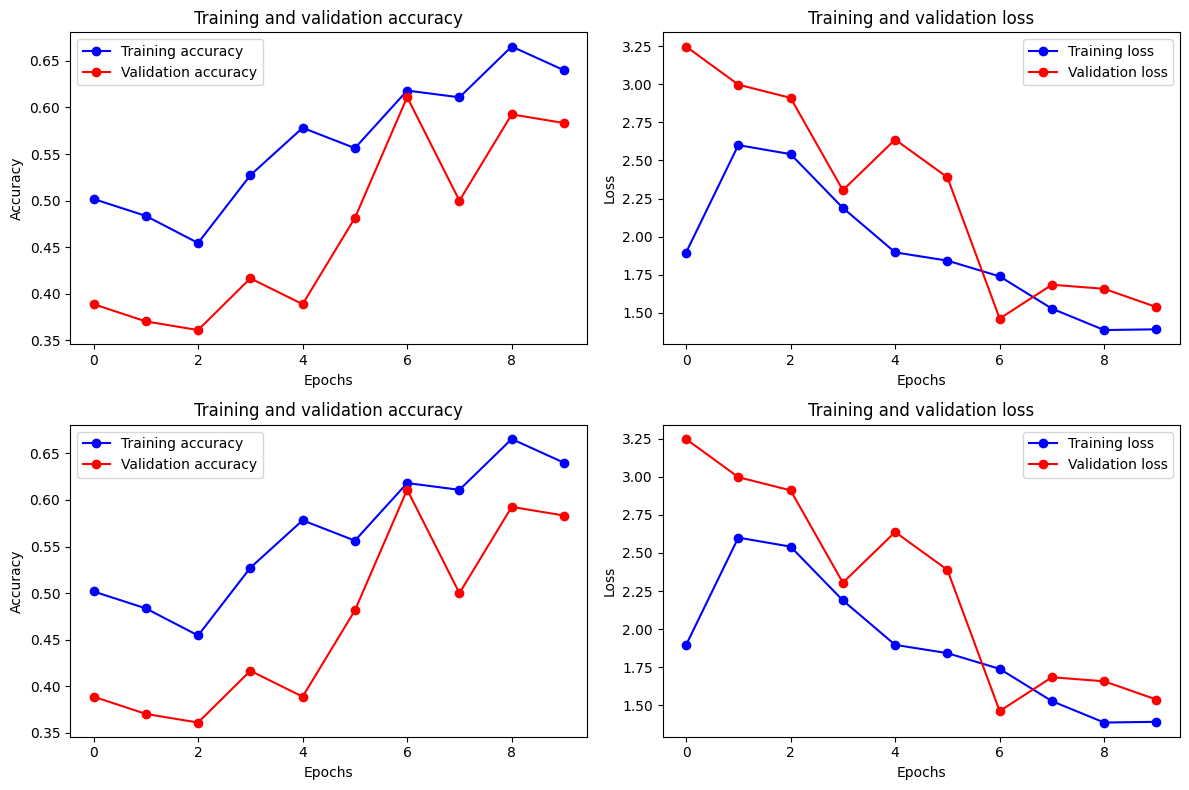

In [83]:

def plot_history(history):
    acc = np.array(history.history['accuracy'])
    val_acc = np.array(history.history['val_accuracy'])
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])

    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot training and validation accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'history' is the History object returned from model.fit
plot_history(history)

In [ ]:
%tensorboard --logdir logs/fit

In [46]:
import os
import time
import subprocess
from IPython.display import display, HTML

os.system('pkill -f "tensorboard"')
subprocess.Popen(["tensorboard", "--logdir", "logs/fit"])
time.sleep(5)
display(HTML(f'<a href="http://localhost:6006" target="_blank">Open TensorBoard</a>'))

## Test model on real images


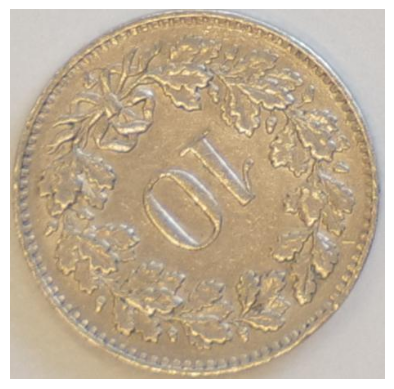

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Class           Probability
------------------------------
0.1CHF          : 0.8396
0.2CHF          : 0.1117
5CHF            : 0.0406
0.05CHF         : 0.0033
OOD             : 0.0020
0.2EUR          : 0.0008
0.5CHF          : 0.0007
0.05EUR         : 0.0005
0.1EUR          : 0.0002
1CHF            : 0.0002
2CHF            : 0.0001
0.01EUR         : 0.0001
2EUR            : 0.0000
0.02EUR         : 0.0000
1EUR            : 0.0000
0.5EUR          : 0.0000


In [79]:
def predict_images(path):
    # Load and display the image
    img = mpimg.imread(path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.show()

    # Preprocess the image
    image = Image.open(path)
    image = image.convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image) / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Expand dimensions to fit model input

    # Predict the probabilities
    probabilities = model.predict(image)

    # Get class labels
    class_labels = {v: k for k, v in val_generator.class_indices.items()}

    # Prepare data for a nice display
    sorted_indices = np.argsort(probabilities[0])[::-1]
    results = [(class_labels[i], probabilities[0][i]) for i in sorted_indices]

    # Print sorted probabilities and their corresponding class labels
    print("Class".ljust(15), "Probability")
    print("-" * 30)
    for label, prob in results:
        print(f"{label.ljust(15)} : {prob:.4f}")

# Example usage
predict_images('./Extracted_Training_Data/0.1CHF/L1010279_3.JPG')

## Confustion matrix on validation set

7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step


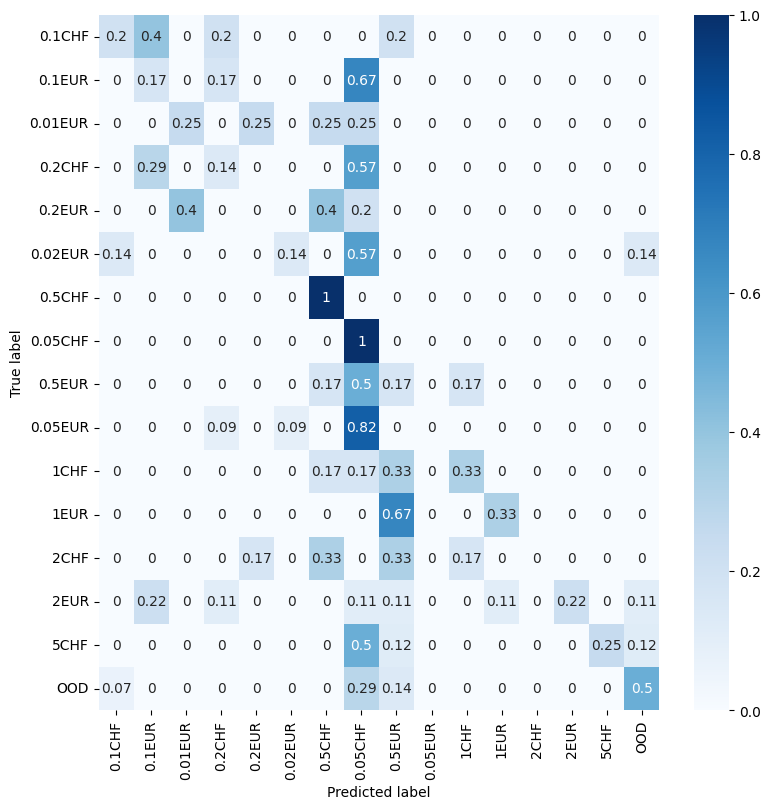

In [84]:
import pandas as pd
import seaborn as sns

Y_pred = model.predict(val_generator, 1167//32+1)
y_pred = np.argmax(Y_pred, axis=1)
cfm = confusion_matrix(val_generator.classes, y_pred)
cfm = np.around(cfm.astype('float')/cfm.sum(axis=1)[:, np.newaxis], decimals=2)
classes = ['0.1CHF', '0.1EUR', '0.01EUR', '0.2CHF', '0.2EUR', '0.02EUR', '0.5CHF', '0.05CHF', '0.5EUR', '0.05EUR', '1CHF', '1EUR', '2CHF', '2EUR', '5CHF', 'OOD']
cfm_pd = pd.DataFrame(cfm, index = classes, columns = classes)
figure = plt.figure(figsize=(8,8))
sns.heatmap(cfm_pd, annot=True, cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

